In [1]:
# load .py file with all functions
from function_XGB import *
cwd = os.getcwd()
print("Current working directory: ", cwd)

Python version: 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:14:58) [MSC v.1929 64 bit (AMD64)]
NumPy version: 1.23.3
Pandas version: 1.5.3
scikit-learn version: 1.2.2
xgboost version: 1.7.4
Matplotlib version: 3.7.1
Current working directory:  f:\NEON_gapfill


# working directory

In [2]:
sitename = "BART_NEON"
site_data_dir = Path(f"F:/NEON_gapfill/") # local working environment
# site_data_dir = Path("/home/jovyan") # binder working directory
model_dir = site_data_dir / "XGB_models"
model_dir.mkdir(exist_ok=True)
data_train_test_dir = site_data_dir / "FC_data_train_test"
data_train_test_dir.mkdir(exist_ok=True)

# input features and target variable


In [3]:
predictors = ['TIMESTAMP_END', 'GCC', 'EVI', 'Tair', 'VPD', 'PPFD']
y_col = "NEE_for_gapfill"

# load data

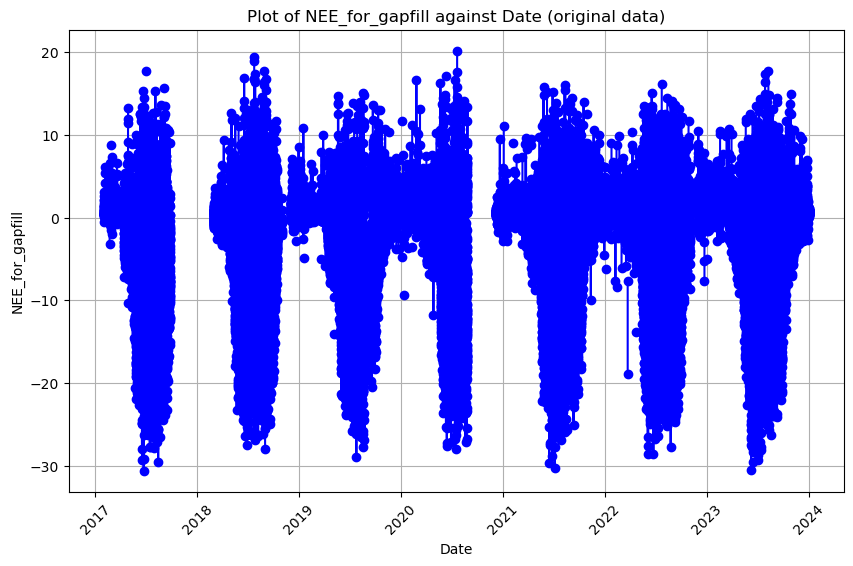

In [4]:
site_name = "BART_NEON"
file_name = f"data_for_XGB_{site_name}.csv"  
site_data, site_data_no_na = load_data(site_data_dir, file_name, y_col)

# 01 find the best hyperparameters

In [10]:
# find_hyperparameters(site_data_no_na, predictors, y_col, model_dir) 
# this line takes a long time to run (> 5 hours), please skip it and load the saved model to test the rest of the script

In [5]:
# load the model after hyperparameter tuning
model_path = (model_dir ) / "FC_XGB_model.pkl"
with open(model_path, 'rb') as f:
    reg = pkl.load(f)
reg

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=50, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

# 02 model performance

In [ ]:
# create_train_test_folds(site_data, site_data_dir, y_col) 
# I saved 10 fold train and test data under / data_train_test_dir, then read in the data in the check_model_performance, which is not very efficient

Train/test files saved in F:\NEON_gapfill\FC_data_train_test


Processing Fold 1...


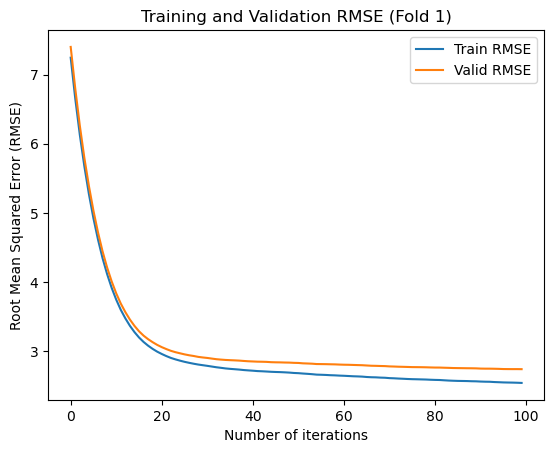

{'RMSE': 2.7382597812301377, 'R2': 0.8477681750152175, 'MAPE': 86.04278694914169}
Processing Fold 2...


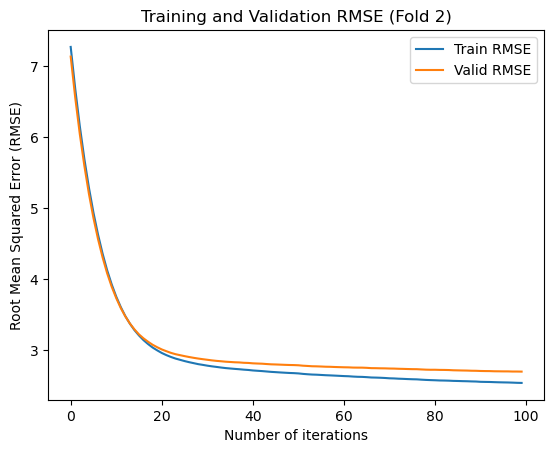

{'RMSE': 2.6965154876887434, 'R2': 0.8462936456690411, 'MAPE': 76.93361860897723}
Processing Fold 3...


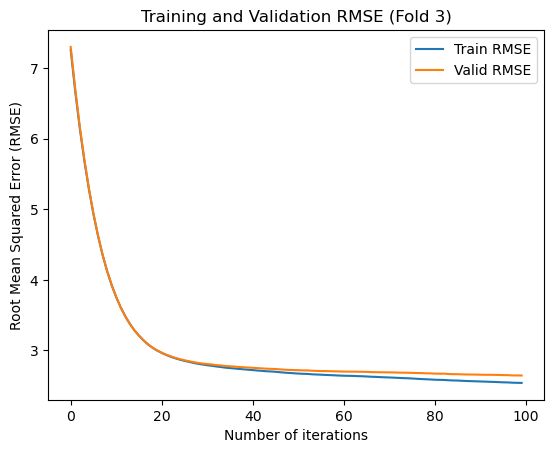

{'RMSE': 2.6457693749093534, 'R2': 0.8564017119903824, 'MAPE': 82.94355972615635}
Processing Fold 4...


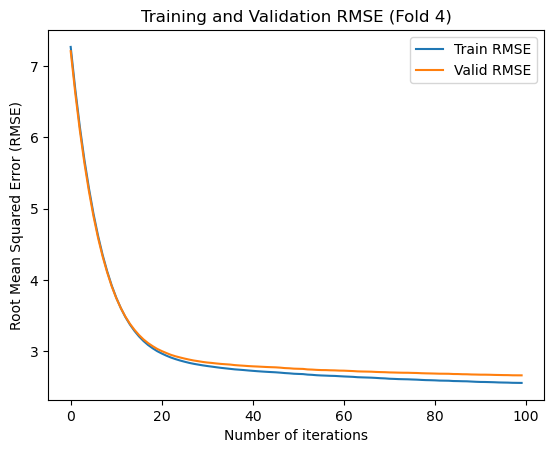

{'RMSE': 2.663816367323233, 'R2': 0.8529700106180056, 'MAPE': 85.47832491772125}
Processing Fold 5...


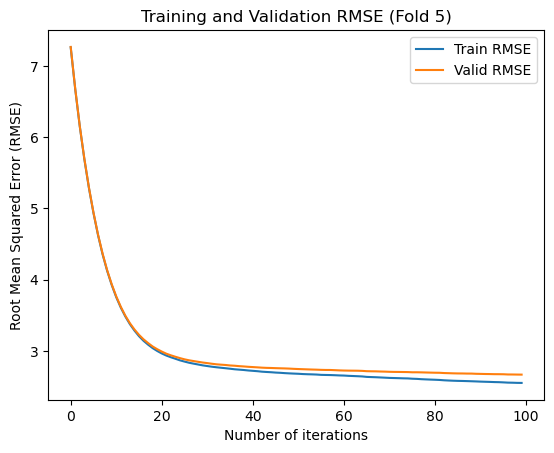

{'RMSE': 2.6660556158777564, 'R2': 0.853865138253866, 'MAPE': 80.47071724885555}
Processing Fold 6...


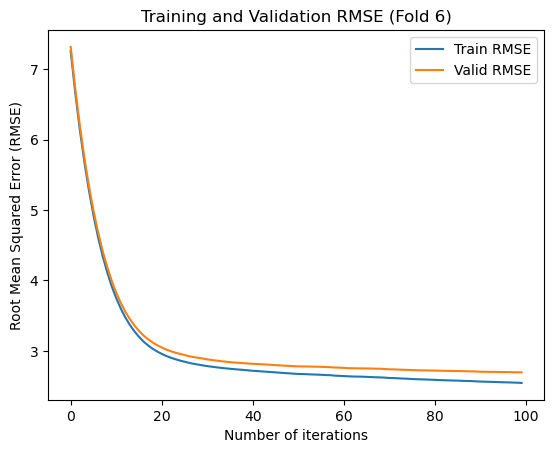

{'RMSE': 2.694821277998926, 'R2': 0.8527371540871369, 'MAPE': 75.60794785983067}
Processing Fold 7...


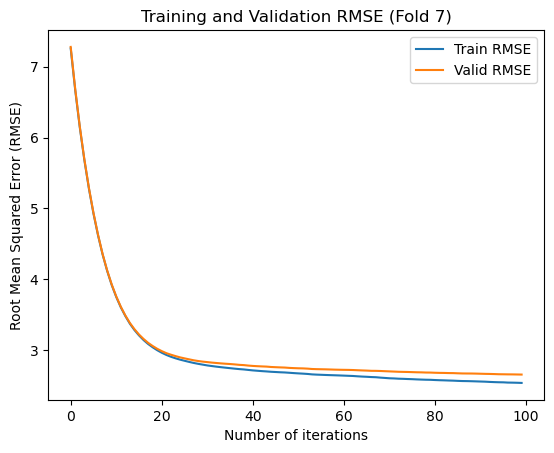

{'RMSE': 2.654784789866494, 'R2': 0.853863590126916, 'MAPE': 81.51747110905079}
Processing Fold 8...


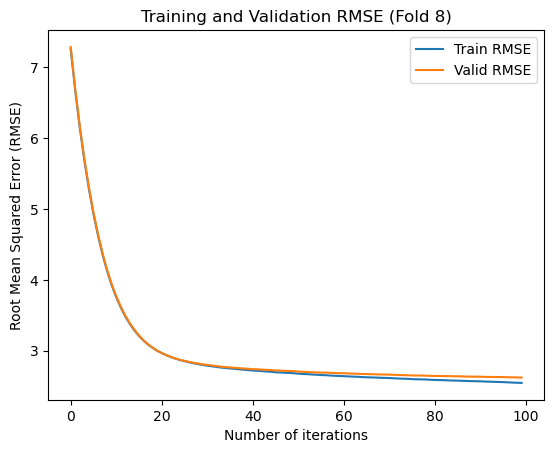

{'RMSE': 2.6207707393017894, 'R2': 0.8581889143127666, 'MAPE': 76.53541412158322}
Processing Fold 9...


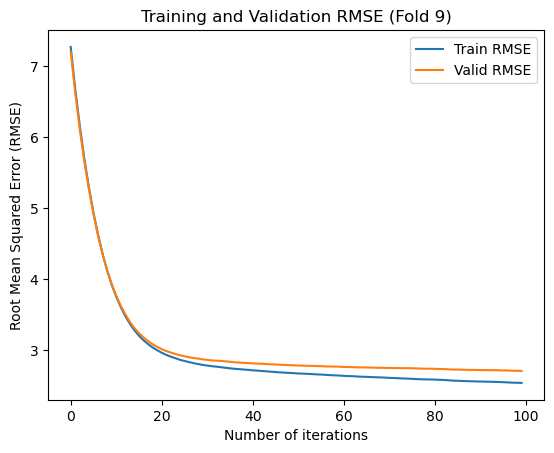

{'RMSE': 2.705558517533841, 'R2': 0.8466477392441294, 'MAPE': 90.70683240336508}
Processing Fold 10...


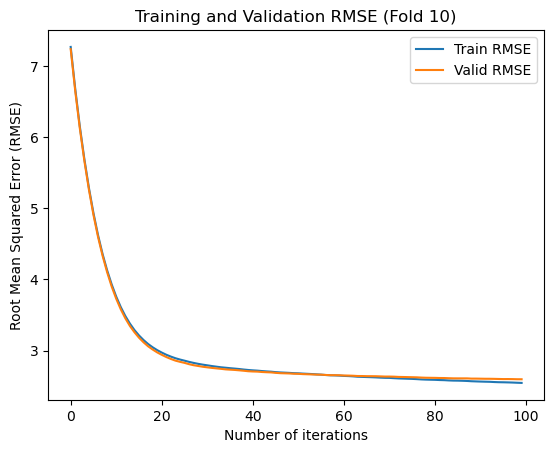

{'RMSE': 2.5976466116283508, 'R2': 0.8605121307953629, 'MAPE': 76.68465721412694}
--------------------------------------------------------

Mean RMSE: 2.668 ± 0.040
Mean R²: 0.853 ± 0.005
Mean MAPE: 81.292 ± 4.768
--------------------------------------------------------


In [6]:
check_model_performance(data_train_test_dir, predictors, y_col, reg)

# 03 do gapfill 

In [7]:
get_accurate_prediction(site_data, site_data_no_na, predictors, y_col, site_data_dir, reg)

Predictions saved to: F:\NEON_gapfill\FC_XGB_prediction.csv


,Year,Day,Hour,Date,Month,DOY,TIMESTAMP_END,GCC,EVI,Tair,...,DOY_sin,DOY_cos,NEE_for_gapfill,PPFD,H_for_gapfill,LE_for_gapfill,P_7day,P_30day,XGB_FC_fall,XGB_FC_f
0,2017,1,0.5,2017-01-01,1,1,201701010030,0.34364,0.215800,-4.892428,...,0.017166,0.999853,NaN,-2.8571,NaN,NaN,0.000,0.0,0.889005,0.889005
1,2017,1,1.0,2017-01-01,1,1,201701010100,0.34364,0.215800,-4.475620,...,0.017166,0.999853,NaN,-2.8571,NaN,NaN,0.000,0.0,0.889005,0.889005
2,2017,1,1.5,2017-01-01,1,1,201701010130,0.34364,0.215800,-4.684024,...,0.017166,0.999853,NaN,-2.8571,NaN,NaN,0.000,0.0,0.889005,0.889005
3,2017,1,2.0,2017-01-01,1,1,201701010200,0.34364,0.215800,-4.713796,...,0.017166,0.999853,NaN,-2.8571,NaN,NaN,0.000,0.0,0.889005,0.889005
4,2017,1,2.5,2017-01-01,1,1,201701010230,0.34364,0.215800,-4.753492,...,0.017166,0.999853,NaN,-2.8571,NaN,NaN,0.000,0.0,0.889005,0.889005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122673,2023,31,17.0,2023-12-31,12,365,202312311700,0.34500,0.242523,-4.352200,...,-0.017166,0.999853,NaN,0.6200,-17.674933,5.915219,18.611,232.3,0.862508,0.862508
122674,2023,31,17.5,2023-12-31,12,365,202312311730,0.34500,0.242523,-4.543100,...,-0.017166,0.999853,NaN,0.1400,-19.945106,1.918483,18.611,232.3,0.874653,0.874653
122675,2023,31,18.0,2023-12-31,12,365,202312311800,0.34500,0.242523,-4.665800,...,-0.017166,0.999853,NaN,0.1400,-24.592497,7.285188,18.611,232.3,0.874653,0.874653
122676,2023,31,18.5,2023-12-31,12,365,202312311830,0.34500,0.242523,-4.818400,...,-0.017166,0.999853,1.194168,0.1500,-44.558458,12.799249,18.611,232.3,0.874653,1.194168


# 04 feature importances

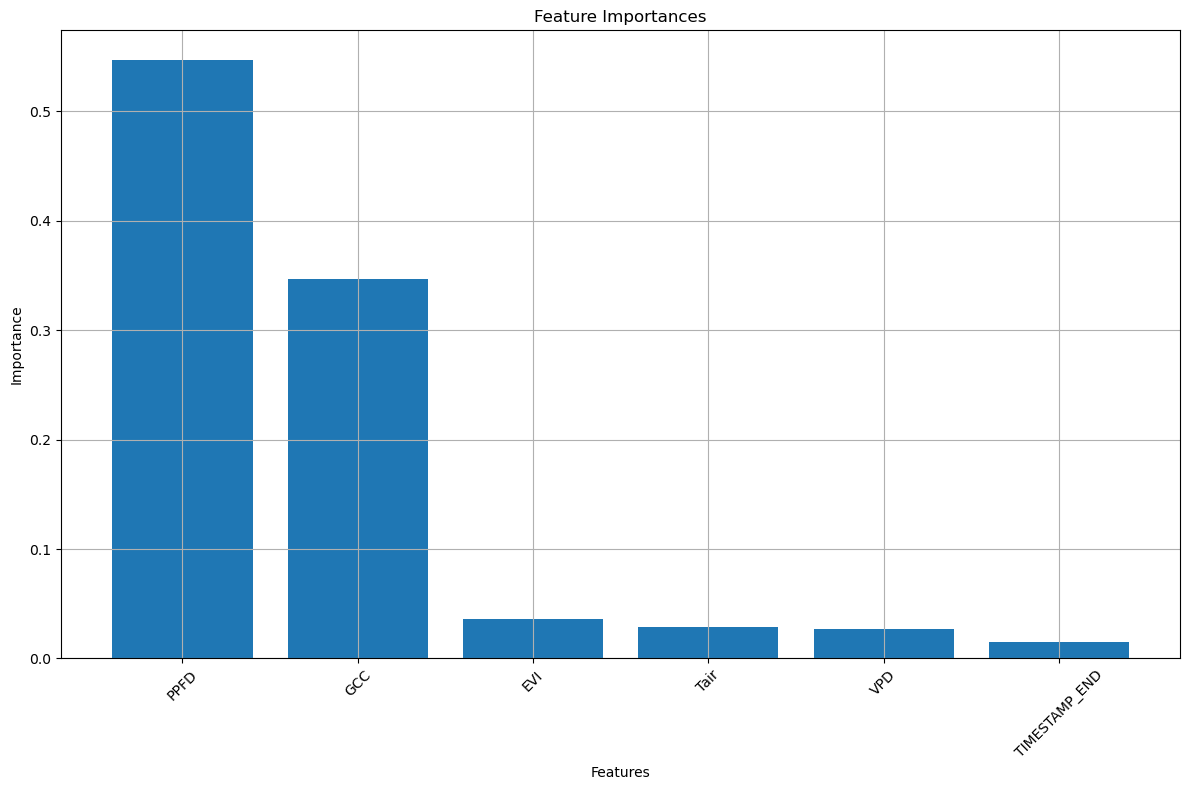

,Feature_Importances,predictors
5,0.546623,PPFD
1,0.347140,GCC
2,0.036111,EVI
3,0.028899,Tair
4,0.026648,VPD
0,0.014580,TIMESTAMP_END


In [8]:
feature_importance(site_data_no_na, predictors, y_col, site_data_dir, reg)

# 05 annual sums and monthly sums

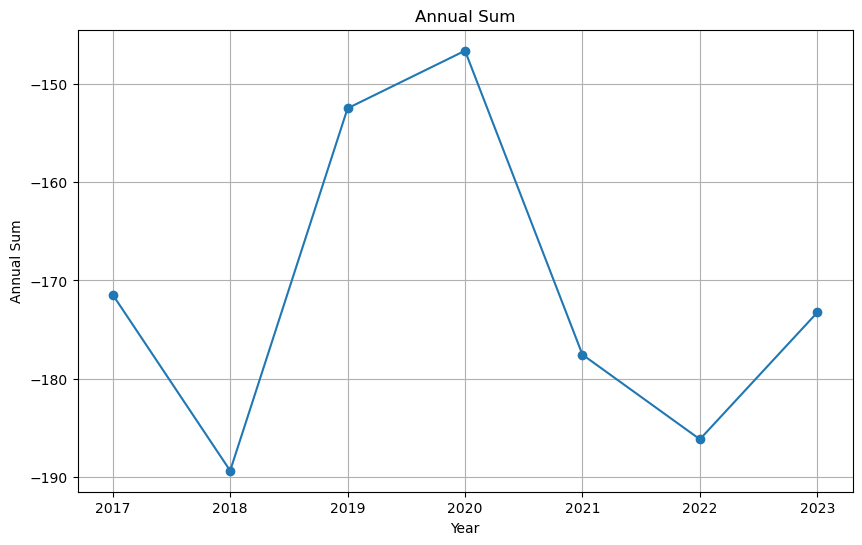

,Year,annual_sum
0,2017,-171.448201
1,2018,-189.329391
2,2019,-152.504104
3,2020,-146.654508
4,2021,-177.535801
5,2022,-186.133797
6,2023,-173.248944


In [9]:
data_prediction = pd.read_csv(site_data_dir/ "FC_XGB_prediction.csv")
cal_annual_sum(data_prediction, "XGB_FC_f", 2017, 2023, site_data_dir)

Check if you have 'Month' and 'Year' columns in input data!


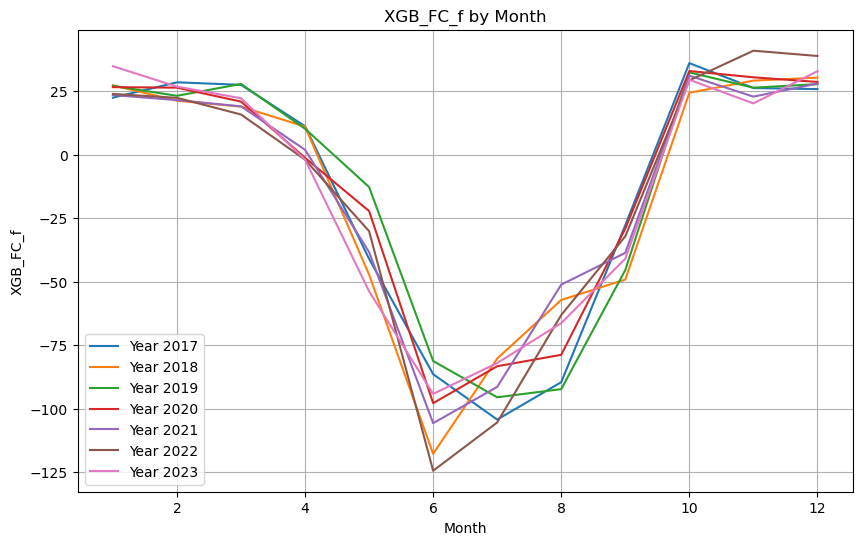

,Year,Month,monthly_sum
0,2017,1,22.408594
1,2017,2,28.452132
2,2017,3,27.463248
3,2017,4,11.173214
4,2017,5,-41.014979
...,...,...,...
79,2023,8,-66.288208
80,2023,9,-40.938630
81,2023,10,29.454456
82,2023,11,20.157589


In [10]:
cal_monthly_sum(data_prediction, "XGB_FC_f", 2017, 2023, site_data_dir)